In [94]:
# !jupyter nbconvert --no-prompt --to python dotifsetc.ipynb 

[NbConvertApp] Converting notebook dotifsetc.ipynb to python
[NbConvertApp] Writing 37144 bytes to dotifsetc.py


In [82]:
# ###############################################################################
 
# Copyright (C) 2021, Haeun Chung
# E-mail: haeunchung@arizona.edu

# This software is provided as is without any warranty whatsoever.
# Permission to use, for non-commercial purposes is granted.
# Permission to modify for personal or internal use is granted,
# provided this copyright and disclaimer are included unchanged
# at the beginning of the file. All other rights are reserved.
# ###############################################################################

# NAME: dotifsetc()
  
# PURPOSE:
#     DOTIFS exposure time calculator (ETC, or S/N calculator) is developed to 
#     provide expected signal to noise ratio information in various observing
#     conditions and targets to community users who are observing or planing
#     to do observation with Devasthal Optical Telescope Integral Field
#     Spectrograph (DOTIFS).

# REQUIRED PACKAGES:
#     packages with lower than below versions would also work.
#     NUMPY: 1.14.3
#     SCIPY: 1.1.0
#     MATPLOTLIB: 2.2.2
#     DOTIFSETC_UTIL: included in the distribution.
    
# CALLING SEQUENCE:
#     from dotifsetc import dotifsetc
    
#     result=dotifsetc(exptime=3600, band='r', magnitude=20., skymagnitude=22,
#                      oname='dotifs_snr.ps', source='obj_sc', z=0., stype=0, 
#                      wstep=(3700./3000), pixel=None, ltrghost=False, 
#                      soc=False, skysub=True, wavearr=None, inputflux=None, 
#                      inputwave=None, show=False, save=False, 
#                      plotrange=[3700, 7400], run=True)
    
#     print(result.wave)
#     print(result.sourceflux)
#     print(result.snr)
#     print(result.signal)
#     result.show=True
#     result.plot()
    
#     dotifsetc() without any parameters will also work and give result with
#     predefined observing condition.
    
# INPUT PARAMETERS:
#     EXPTIME: exposure time in seconds (default: 900 seconds)
#     BAND: photometric band which will be used to calculate source flux. 
#         Only SDSS ugriz bands are supported. (default: 'r')
#     MAGNITUDE: source magnitude at the defined photometric band. The template 
#         flux will be scaled based on this input magnitude. (AB magnitude)
#         (default: 17 mag)
#     SKYMAGNITUDE: sky magnitude at the defined photometric band. The template 
#         flux will be scaled based on this input magnitude. (AB magnitude)
#         (default: 17 mag)
#     ONAME: name of output file (default: 'dotifs_snr.ps')
#     SOURCE: target name. ETC read SED of selected target from target
#         templates or generate SED based on target option. source parameter is
#         comprised of two strings - source type and value. available source 
#         type and value is listed as below. (default: 'obj_sc')
#         source types(source values):
#             obj(s0, sa, sb, sc, bulge, elliptical, starb1, starb2, starb3,
#                 starb4, starb5, starb6): model spectrum of various targets.
#                 data is obtained from kc96.
#                 (http://www.stsci.edu/hst/observatory/crds/cdbs_kc96.html)
#             arcflat(Xenon): spectrum of Xenon arc lamp. data from Newport
#                 catalog.
#             wavecal(Kr, HgNe, KrHgNe): spectrum of wavelength calibration
#                 sources.
#             sky: spectrum of sky at various geometry between Sun, Moon, Earth 
#                 and target. source value of this type of object is provided 
#                 separately using stype parameter.
#             blackbody(temparature in Kelvin): blackbody spectrum which follows 
#                 Planck distribution.
#             const: flux with constant magnitude.
#             Example: 
#                 sa galaxy: dotifsetc(source='obj_sa')
#                 elliptical galaxy: dotifsetc(source='obj_elliptical')
#                 arcflat: dotifsetc(source='arcflat_Xenon')
#                 sky: dotifsetc(source='sky', stype=0)
#                      dotifsetc(source='sky', stype='p0_p135_n90_p45')
#                 blackbody: dotifsetc(source='blackbody_5500')
#                 const: dotifsetc(source='const')
#     Z: redshift of the source. target SED will be redshifted according to this
#         input parameter. It works only when source type is obj.
#         (default: 0.000)
#     STYPE: sky type selecting parameter. 
#         format: mssep_mtsep_malt_talt
#             the format indicates spectrum of sky at various geometry
#             between Sun, Moon, Earth and target. all in degrees. data is
#             obtained from ESO sky calculator.
#             (https://www.eso.org/observing/etc/skycalc/) Predefined options 
#             are listed in the description of STYPE parameter. 
#             mssep(moon-sun separation), mtsep(moon-target separation),
#             malt(moon altitude), talt(target altitude)
#             there are more options on model sky spectrum, and users may
#             use one with their preferred option by putting model sky file
#             (in photon count) at sky_spectrum directory and modify 
#             sky_templates.fmt file to let etc to understand the file.
#         user can choose model either by option index or model name. 
#         currently, only four sky template spectrum models are supported as a 
#         below list. (default: 0)
#         model options:
#             p0_p135_n90_p45: newmoon, target altitude = 45 degrees.
#             p90_p90_p45_p45: halfmoon. 
#                 moon and target altitude = 45 degrees.
#                 separation between moon and target = 90 degrees.
#             p180_p90_p45_p45: fullmooon. 
#                 moon and target altitude = 45 degrees.
#                 separation between moon and target = 90 degrees.
#     AIRMASS: airmass of the target. This airmass value is used to calculate
#         the sky transmission using the sky extinction data (default: 1)
#     WSTEP: wavelength step size of the output spectra in Angstrom.
#         (default: 1.233 angstrom)
#     PIXEL: wavelength step size in pixel unit. if this pixel parameter is 
#         defined, then wstep parameter will be ignored.
#         (default: None)
#     LTRGHOST: set this keyword to on/off littrow ghost on top of the source 
#         spectrum. (default: False)
#     SOC: set this keyword to on/off second order contamion on top of the 
#         source spectrum. (default: False)
#     SKYSUB: set this keyword to show skysubtracted result. (default: False)
#         when this keyword is True, output S/N, signal, and noise count is
#         sky-subtracted result. user can obtain identical result by manually
#         calculate the result from non-skysubtracted observation result and
#         sky observation result. 
#         Example:
#             wosky=dotifsetc(source='obj_sc', magnitude=20, skymagnitude=22, 
#                             skysub=True) #sky subtracted
#             wsky=dotifsetc(source='obj_sc', magnitude=20, skymagnitude=22,
#                            skysub=False) #sky non-subtracted result
#             sky=dotifsetc(source='sky', magnitude=22, skysub=False)
#             wosky.signal=wsky.signal-sky.signal
#             wosky.noise=(wsky.noise**2+sky.noise**2)**0.5
#     WAVEARR: user can use their own wavelength grid by providing wavelength
#         vecton in numpy array format. WSTEP and PIXEL parameters will not be
#         used when this parameter is provided. (default: None)
#     INPUTFLUX: user can use user defined source flux as a source of ETC 
#         in unit of erg/s/cm^2/Ang. inputwave should be provided as well.
#         (default: None)
#     INPUTWAVE: wavelength of inputflux in angstrom. (default: None)
#     SKYTRANS: set this keyword to the bandname of the sky transmission file
#          as written in the response_curves.fmt file, if a user wants to use
#          sky transmission file instead of sky extinction file. 
#          For example, if set this keyword as 'default', then the sky 
#          transmission is calculated from the extinction data 
#          ('sky_extinction.dat'). The data format of the extinction data 
#          should be 'wavelength' at column 1 and 'mag/airmass' at column 2.
#          If set this keyword as 'skytrans', then the 
#          'sky_transmission_eso_sky_calc.dat' will be used. AIRMASS keyword
#          will be ignored in this case.
#          (default: False)
#     RMEDSN: set this keyword to return an median SN value among band. 
#         Range of band is determined by BAND parameter. Two bands are 
#         supported: 'g' and 'r' (default: False)
#     TSCALE: user can scale the entire throughput of the optics by changing
#         this parameter (default: 1)
#     SHOW: set this keyword to view the result with matplotlib window.
#         (default: False)
#     SAVE: set this keyword to save the plot in the output file. 
#         (default: False)
#     PLOTRANGE: set the wavelength range of the result plot in two elements
#         list format. (wavelength in angstrom) (default: [3700,7400])
#     RUN: set this keyword to calculate the result when dotifsetc class is 
#         generated. (default: True)

# ADDITIONAL INPUT PARAMETERS:
#     user can modify below parameters as attributes of the dotifsetc class.
#     user should execute dotifsetc.run() function to get the new result.
#     .ITPKIND: choose interpolation method to interpolate the parameter vector
#         on the output wavelength grid. available options are listed as below.
#         (default: 'cubic') 
#         options: 'linear', 'nearest', 'zero','slinear', 'quadratic', 'cubic', 
#         'previous', 'next'
#         detail of each method is described in the scipy documentation. 
#         (scipy.interpolate.interp1d)
#     .PRI: telescope primary mirror diameter in meter (default: 3.6)
#     .SEC: telescope secondary mirror diameter in meter (default: 0.915)
#     .SOURCESAMPLINGSIZE: size of one spatial element in square arcsecond. 
#         Useful to set this as 1 if one wants to use this exposure time
#         calculator for single object. For exmaple, the calculator can be
#         used to estimate the S/N of MOS target, by setting this keyword as
#         1, MAGNITUDE as a fiber magnitude and SKYSAMPLINGSIZE as a field of
#         view of fiber.
#         (default: 0.831384) (size of hexagon with 0.4 arcsecond side)
#     .SKYSAMPLINGSIZE: set this keyword to the size of spatial element. 
#         if None, the value will be the same as SOURCESAMPLINGSIZE.
#         (default: None) 
#     .DISPERSION: dispersion of the spectrograph in Angstrom per micron.
#         (default: 0.082222) 
#     .PIXELSIZE: size of CCD pixel in micron. (default: 15)
#     .NPIX_SPA: size of PSF on CCD along spatial direction in pixel unit. 
#         this number is used to calculate readout noise count at each 
#         wavelength bin. (default: 5)
#     .RN: readout noise count in electron (default: 2)
#     .DARK: dark current in unit of electron per an hour per pixel. 
#         (default: 0)
    
# OUTPUT PARAMETERS:
#     user can read output parameters as attributes of the dotifsetc class.
#     .SOURCEFLUX: SED of input template in unit of erg/cm2/sec/angstrom.
#     .WAVE: wavelength of SED
#     .SNR: signal to noise ratio
#     .SIGNAL: electron signal count of the given observation.
#     .NOISE: electron noise count of the given observation. this is
#         quadrature summation of noises from source, (sky), readout, and
#         dark current.

# EXAMPLES:
#     from dotifsetc import dotifsetc
#     to view the result of below examples, user should save them in a
#     variable as result=dotifsetc(), or set show=True, or set save=True 
#     - Test run:
#         dotifsetc(show=True, save=True)
#         matplotlib window will be poped up, and the result will be saved
#         in 'dotifs_snr.ps' file.
#     - r band surface brightness=17, Sc type galaxy at redshift z=0.04, 
#     10 minutes exposure with output name of 'Sc_rmag17_z0.04.ps':
#         dotifsetc(exptime=600, band='r', magnitude=17, source='obj_sc', 
#                   z=0.04, oname='Sc_rmag17_z0.04.ps', save=True)
#     - Sa type galaxy, apply second order contamination, and Littrow 
#     ghost. change wavelength bin size as 2.5 pixels:
#         dotifsetc(source='obj_sa', soc=True, ltrghost=True, pixel=2.5)
#     - Wavelength Calibration source spectrum. (Krypton lamp):
#         dotifsetc(source='wavecal_Kr', exptime=5)
#     - Arc lamp source spectrum. (Xenon lamp):
#         dotifsetc(source='arcflat_Xenon', exptime=5)
#     - sa type galaxy, plotrange from 5000-6800 angstrom:
#         dotifsetc(source='obj_sa', plotrange=[5000,6800])
#     - sa type galaxy, g band surface birightness=18, with fullmoon sky
#         and skymagnitude at g band=20
#         dotifsetc(source='obj_sa', band='g', magnitude=18, stype=2, 
#                   skymagnitude=20)
#     - sa type galaxy, read output data.
#         result=dotifsetc(source='obj_sc')
#         snr=result.snr
#         signal=result.signal
#         noise=result.noise
#         wavelength=result.wave
#     - run ETC after modify some optional parameters. (primary diameter
#         of the telescope as 8 meters, change interpolation scheme as 
#         linear)
#         result=dotifsetc(run=False)
#         result.pri=8
#         result.itpkind='linear'
#         result.save=True
#         result.run()

# NOTE:
#     signal count does not account noise. (noise is not added)
    
# MODIFICATION HISTORY:
#     v1.0.0: Haeun Chung, 2015, Jun. 28, IUCAA, First version
#     v1.1.0: Haeun Chung, 2016, Jun. 9, IUCAA, Modifed for internal 
#             distribution
#     v1.2.0: Haeun Chung, 2017, Oct. 24, SNU, Add calibration sources. 
#             Add Arc lamp source. Fix usd_asahi=1. Add Asachi filter at
#             AOI=10 deg.
#     v1.3.0: Haeun Chung, 2018, Nov. 12, SNU, Add Littrow ghost. Change 
#             gen_cal scheme to add non-zero flux to every pixel
#     v2.0.0: Haeun Chung, 2018, Aug. 8, Translated from IDL to Python 
#             and tested against original version.
#     v2.1.0: Haeun Chung, 2020, May 14, Steward Observatory (Day 57 of 
#             WFH due to COVID-19)
#             - add airmass parameter. Now sky transmission can be 
#             calculated from sky extinction data (mag/airmass). Direct 
#             use of sky transmission data is also available. 
#             - add rmedsn parameter
#             - add tscale parameter
#             - add sourcesampling and skysampling parameter
#             - change interpolation method of sky template file. Now 
#             log10(skyflam) value is interpolated to avoid
#             negative output from cubic interpolation.
#     v2.2.0: Haeun Chung, 2020, Dec. 28, Steward Observatory (still
#             Day ?? of WFH due to COVID-19)
#             - add constant sky option (stype=3)
#             - include dotifs_util functions to main routine
#             - add ESO sky transimission option

In [83]:
import numpy as np
from scipy import constants
from scipy.interpolate import interp1d
import time
from os import path, getcwd
#from os import getcwd
import inspect
from math import pi
import math
import matplotlib
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt

# if __name__=='__main__':
#     import dotifs_util as util
# else:
#     from . import dotifs_util as util


# from .dotifs_util import mag2flux, flux2bpmag, planck
# from dotifs_util import mag2flux, flux2bpmag, planck

In [84]:
def mag2flux(mag, zero_pt=21.1, ABwave=None):
    if np.any(ABwave != None):
         return 10.**(-0.4*(mag+2.406+5*np.log10(ABwave)))
    return 10.**(-0.4*(mag+zero_pt))

In [85]:
def flux2mag(flux, zero_pt=21.1, ABwave=None):
    if np.any(ABwave != None):
        return np.log10(flux)/(-0.4)-2.406-5*np.log10(ABwave)
    return np.log10(flux)/(-0.4)-zero_pt

In [86]:
def planck(wave, temp):
    w=wave/1e8
    c1 =  3.7417749e-5  #=2*!DPI*h*c*c   
    c2 = 1.4387687    # =h*c/k
    val=c2/w/temp
    bbflux=c1/(w**5 * (math.e**val-1))*1e-8
    return bbflux

In [87]:
def flux2bpmag(flam, wave, filtertrans_input, filterwave=None,
               errflag=None, flam_err=None, bpmag_err=None, itpkind='linear'):

    mintrans=0.00011
    filtertrans=np.copy(filtertrans_input)
    if filterwave != None:
        itpfunc=interp1d(filterwave, filtertrans, kind=itpkind)
        filtertrans=itpfunc(wave)
        
    filtertrans=(filtertrans >= mintrans)*filtertrans
    
    nwave=len(wave)

    if len(filtertrans) != nwave:
        errflag=1
        return
    
    constc=constants.c


    flux=np.sum(flam*filtertrans)

    
    refflam=np.ones(nwave)*3631e-23/(wave**2.)*constc*1e10
    refflux=np.sum(refflam*filtertrans)

    if flam_err != None:
        err=(np.sum((flam_err*filtertrans)**2))**0.5
        bpmag_err=-2.5/np.log(10)/flux*err

    bpmag=-2.5*np.log10(flux/refflux)
    return bpmag

In [88]:
def gen_cal(wave, cdir, calname):
    calfile=readdata(cdir, 'calibration',calname)
    lwave=calfile.wave
    lflux=calfile.value
                
    nline=len(lwave)
    nwave=len(wave)
    flux_out=wave*0.
    
    for i in range(nline):
        if (lwave[i] < wave[0]) or (lwave[i] > wave[-1]):
            continue
        diff=np.absolute(wave-lwave[i])
        sort_idx=np.argsort(diff)
        nrst_idx=sort_idx[0]
        if nrst_idx == (len(wave)-1):
            continue
        binsize=wave[nrst_idx+1]-wave[nrst_idx]
        nflux=lflux[i]/binsize
        flux_out[nrst_idx]=nflux*1e-12
    return flux_out     

In [89]:
def return_littrow_ghost(wave, signal, ccdreflect, cam, g1stR, g1st, g0th):
    rsub=0.01 #;reflectivity of the grating substrate
    lghost1=np.sum(signal*ccdreflect*cam*cam*g1stR)
    lghost2=np.sum(signal*ccdreflect*cam*cam*g1st*rsub*g0th)
    lgwave=4800.
    lghost=signal*0

    diff=np.absolute(wave-lgwave)
    sort_idx=np.argsort(diff)
    nrst_idx=sort_idx[0]
    binsize=wave[nrst_idx+1]-wave[nrst_idx]
    

    tghost=(lghost1+lghost2)
    
    lghost[nrst_idx]=tghost
    return lghost

In [90]:
class readdata:
    def __init__(self, cdir, category, item, skiprows=0, datacol=1):
        cat_file=cdir+category+'/'+category+'.fmt'
        cat_str=np.loadtxt(cat_file, usecols=(0,1), dtype=str)
        cat_factor=np.loadtxt(cat_file, usecols=(2,3), dtype=float)
        
        arr=cat_str[:,0]
        
        if category =='sky_templates':
            skiprows=37
            if type(item) == int:
                ridx=[item]
            else:
                ridx=np.flatnonzero(arr == item)
        else:
            ridx=np.flatnonzero(arr == item)
        
        data_file=cdir+category+'/'+cat_str[ridx[0],1]

        data=np.loadtxt(data_file, usecols=(0,datacol), dtype=float,
                        skiprows=skiprows)
        self.name=cat_str[ridx[0],0]

        self.wave=data[:,0]*cat_factor[ridx[0],0]
        self.value=data[:,1]*cat_factor[ridx[0],1]

In [91]:
def interp(rdclass, xnew,itpkind='cubic', itpfillvalue="extrapolate"):
    itpfunc=interp1d(rdclass.wave, rdclass.value, 
                                       kind=itpkind, fill_value=itpfillvalue)
    return itpfunc(xnew)
#*((xnew >= min(rdclass.wave)) & (xnew <= max(rdclass.wave)))

In [92]:
class dotifsetc(object):
    def __init__(self, exptime=3600, band='r', magnitude=20., skymagnitude=22,
                 oname='dotifs_snr.ps', source='obj_sc', z=0., stype=0, 
                 airmass=1,
                 wstep=(3700./3000), pixel=None, ltrghost=False, soc=False, 
                 skysub=True, wavearr=None, inputflux=None, inputwave=None,
                 skysamplingsize=None, sourcesamplingsize=(3**(1.5))*(0.4**2),
                 skytrans=False, rmedsn=False, tscale=1,
                 show=False, save=False, plotrange=[3700, 7400], run=True
                ):
        
#         define essential parameters as self attributes
            
#         input paramters
        self.exptime=exptime
        self.band=band
        self.magnitude=magnitude
        self.skymagnitude=skymagnitude
        self.oname=oname
        self.source=source
        self.z=z
        self.stype=stype
        self.wstep=wstep
        self.pixel=pixel
        self.ltrghost=ltrghost
        self.soc=soc
        self.skysub=skysub
        self.show=show
        self.save=save
        self.plotrange=plotrange
        self.wavearr=wavearr
        self.inputflux=inputflux
        self.inputwave=inputwave
        self.skytrans=skytrans
        self.airmass=airmass
        self.tscale=tscale
        self.rmedsn=rmedsn
    
        
#         optional input parameters
        self.itpkind='cubic'
        self.pri=3.6
        self.sec=0.915
        self.sourcesamplingsize=sourcesamplingsize
        if skysamplingsize == None:
            self.skysamplingsize=sourcesamplingsize
        else:
            self.skysamplingsize=skysamplingsize
        self.dispersion=3700/(3000*15)
        self.pixelsize=15
        self.npix_spa=5
        self.rn=2
        self.dark=0.02
        self.ifutrans=0.85*0.9
        self.mwstep=0.1
        
#         internally defined parameters
        if '__file__' in globals():
            cdir=path.dirname(path.realpath(__file__))+'/'
        else:
            cdir=getcwd()+'/'
        
        self.cdir=cdir
        self.consth=constants.h
        self.constc=constants.c
#         self.bwaverng=[2000,10000.]
        self.bwaverng=[3300,9500.]
        self.itpfillvalue='extrapolate'
        self.ncol=7
        self.ncam=9
        
        if run == True:
            self.run()
        
    def run(self):
        self.pixelscale=self.dispersion*self.pixelsize
        if self.pixel != None:
            self.wstep=self.pixel*self.pixelscale
        if self.pixel == None:
            self.pixel=self.wstep/self.pixelscale
                    
        ifutrans=self.ifutrans
        telaream2=(self.pri**2-self.sec**2)/4*pi         #in m^2
        telarea=telaream2*1e4                           #in cm^2
        
        
        exptime=self.exptime
        band=self.band
        magnitude=self.magnitude
        skymagnitude=self.skymagnitude
        oname=self.oname
        source=self.source
        z=self.z
        stype=self.stype
        wstep=self.wstep
        pixel=self.pixel
        skytrans=self.skytrans
        airmass=self.airmass

        plotrange=self.plotrange
        itpkind=self.itpkind
        sourcesamplingsize=self.sourcesamplingsize
        skysamplingsize=self.skysamplingsize
    
        
        wavearr=self.wavearr
        inputflux=self.inputflux
        inputwave=self.inputwave
        
        cdir=self.cdir
        consth=self.consth
        constc=self.constc
        itpfillvalue=self.itpfillvalue
        bwaverng=self.bwaverng
        
        stwave=self.plotrange[0]
        edwave=self.plotrange[1]
        mwstep=self.mwstep
        
        if wavearr == None:
            nwave=int((bwaverng[-1]-bwaverng[0])/wstep)+1
            wave=np.linspace(0, nwave-1, num=nwave)*wstep+bwaverng[0]
            diffwave=wave-stwave
            abovezeroidx=np.nonzero(diffwave >=0)
            offwave=min(diffwave[abovezeroidx])
            wave=wave-offwave
        else:
            wave=np.array(wavearr)
            nwave=len(wavearr)

        #define master wave (fine grid)
        
            
        
        if skytrans:
            tsky=interp(readdata(cdir, 'response_curves',skytrans),
                        wave,itpkind=itpkind, itpfillvalue=itpfillvalue)
        else:
            sky_data=readdata(cdir, 'response_curves', 'sky')
            sky_data.value=10**(-sky_data.value/2.5*airmass)
            tsky=interp(sky_data, wave, 
                        itpkind=itpkind, itpfillvalue=itpfillvalue)
        
        telmag=interp(readdata(cdir, 'response_curves','telmag'),
                      wave,itpkind=itpkind, itpfillvalue=itpfillvalue)
        col=interp(readdata(cdir, 'response_curves','col'),
                   wave,itpkind=itpkind, itpfillvalue=itpfillvalue)
        cam=interp(readdata(cdir, 'response_curves','cam'),
                   wave,itpkind=itpkind, itpfillvalue=itpfillvalue)
        vph=interp(readdata(cdir, 'response_curves','vph'),
                   wave,itpkind=itpkind, itpfillvalue=itpfillvalue)
        coat=interp(readdata(cdir, 'response_curves','coating', datacol=4),
                    wave,itpkind=itpkind, itpfillvalue=itpfillvalue)
        ccd=interp(readdata(cdir, 'response_curves','ccd'),
                   wave,itpkind=itpkind, itpfillvalue=itpfillvalue)
        bandt=interp(readdata(cdir, 'response_curves',band),
                     wave,itpkind=itpkind, itpfillvalue=itpfillvalue)
        mg0th=interp(readdata(cdir, 'response_curves','mvph_0th'),
                     wave,itpkind=itpkind, itpfillvalue=itpfillvalue)
        mg1st=interp(readdata(cdir, 'response_curves','mvph_1st'),
                     wave,itpkind=itpkind, itpfillvalue=itpfillvalue)
        mg2nd=interp(readdata(cdir, 'response_curves','mvph_2nd'),
                     wave,itpkind=itpkind, itpfillvalue=itpfillvalue)
        afilter=interp(readdata(cdir, 'response_curves','filter'),
                       wave,itpkind=itpkind, itpfillvalue=itpfillvalue)

        col=col/0.995**(2*self.ncol)*coat**(2*self.ncol)*self.tscale
        cam=cam/0.995**(2*self.ncam)*coat**(2*self.ncam)

        g1st=vph
        g0th=vph/mg1st*mg0th
        g2nd=g1st/mg1st*mg2nd
        g1stR=g1st*5*10.**(-5)

        skyflag=0
        photone=consth*1e7*constc/(wave*1e-10)
        
        if (inputflux != None) & (inputwave != None):
            if (len(inputflux) == len(self.inputwave)):
                itpfunc=interp1d(inputwave, inputflux,
                                 kind=itpkind, fill_value=itpfillvalue)
                sourceflux=itpfunc(self.wave)
                temptitle='user defined input'
                skyflag=1
                calflag=0
        else:
            rtval=self.return_flux(self.source, wave, magnitude, bandt)
            sourceflux, temptitle, skyflag, calflag = rtval

        rtval=self.return_flux('sky', wave, skymagnitude, bandt)
        skyflux, skytemptitle, n2, n3 = rtval
        
        sourcecount=(sourceflux/photone)*wstep*telarea*exptime*sourcesamplingsize
        skycount=(skyflux/photone)*wstep*telarea*exptime*skysamplingsize

        comtrans=telmag*ifutrans*col*afilter*cam*ccd
        t1st=comtrans*g1st
        t2nd=comtrans*g2nd*0.5   

        pc1st=t1st*sourcecount
        pc2nd=t2nd*sourcecount

        if skyflag == 1:
            pc1st=pc1st*tsky
            pc2nd=pc2nd*tsky

        skypc1st=t1st*skycount
        skypc2nd=t2nd*skycount

        wave2nd=wave*2
        itpfunc=interp1d(wave2nd, pc2nd, kind=itpkind,
                         fill_value=itpfillvalue)
        pc2nd=itpfunc(wave)
        
        itpfunc=interp1d(wave2nd, skypc2nd, kind=itpkind, 
                         fill_value=itpfillvalue)
        skypc2nd=itpfunc(wave)


        if self.soc == False:
            pc2nd=pc2nd*0.
            skypc2nd=skypc2nd*0.

        rn_t=self.rn*(self.npix_spa*self.pixel)**0.5
        dark_t=self.dark*exptime/3600.*(self.npix_spa*self.pixel)**0.5

        signal=pc1st+pc2nd

        skysignal=skypc1st+skypc2nd
        if calflag == 1: # observing calibration source or sky
            skysignal=skysignal *0.

        if self.ltrghost == True:
            lghost=return_littrow_ghost(wave,signal+skysignal, (1-ccd), 
                                        cam, g1stR, g1st, g0th)
            signal=signal+lghost
            lghost_sky=return_littrow_ghost(wave,skysignal, (1-ccd), 
                                        cam, g1stR, g1st, g0th)
            skysignal=skysignal+lghost_sky

            
#         if skyflag == 1:#observing target on sky
        if self.skysub == True:
            noise_poisson=(signal+skysignal+rn_t**2+dark_t**2)**0.5
            noise_sky=(skysignal+rn_t**2+dark_t**2)**0.5
            noise=(noise_poisson**2+noise_sky**2)**0.5
        else:
            signal=signal+skysignal
            noise_poisson=(signal+rn_t**2+dark_t**2)**0.5
            noise=noise_poisson
            
        snr=signal/noise

        idx=np.nonzero((wave >= stwave) & (wave <= edwave))
        self.sourceflux=sourceflux[idx]
        self.wave=wave[idx]
        self.snr=snr[idx]
        self.signal=signal[idx]
        self.noise=noise[idx]
        self.sky=skyflux[idx]
        self.throughput=t1st[idx]
        self.temptitle=temptitle
        self.skytemptitle=skytemptitle
        
        #####
        self.signal=signal[idx]
        self.noise=noise[idx]
        self.sourcecount=sourcecount[idx]
        self.pc1st=pc1st[idx]
        self.tsky=tsky[idx]
        self.t1st=t1st[idx]
        #####
        
        if self.rmedsn:
            if band=='r':
                wrr=[5500,7000]
            if band=='g':
                wrr=[3880,5500]
            widx=np.nonzero((self.wave > wrr[0]) & (self.wave < wrr[1]) & np.isfinite(self.snr))
            medsnv=np.median(self.snr[widx])
            return medsnv
        
        if self.show | self.save:
            self.plot()
    
    def return_flux(self, source, wave, magnitude, bandt):
        z=self.z
        exptime=self.exptime
        wstep=self.wstep
        cdir=self.cdir
        stype=self.stype
        itpkind=self.itpkind
        itpfillvalue=self.itpfillvalue
        
     #Identify source type
        consth=constants.h
        constc=constants.c
        src_check=source.split('_')
        src_type=src_check[0]

        if len(src_check) == 2:
            src_value=src_check[1]

        nwave=len(wave)

        if src_type =='const':
            magarr=np.ones(nwave)*magnitude
            sourceflux=mag2flux(magarr, ABwave=wave)
            temptitle='Constant Magnitude of '+str(magnitude)
            skyflag=0
            calflag=1

        if src_type =='obj':
            gal=readdata(cdir, 'target_templates',src_value)
            galwave=gal.wave*(1.+z)
            galflam=gal.value/(1.+z)
            galtempname=src_value

            itpfunc=interp1d(galwave, galflam, kind=itpkind,
                             fill_value=itpfillvalue)
            galflux=itpfunc(wave)

            bpmag=flux2bpmag(galflux, wave, bandt)

            ratio=10.**(-0.4*(magnitude-bpmag))
            sourceflux=ratio*galflux

            wave_cond=(wave >= min(galwave)) & (wave <= max(galwave))
            sourceflux=sourceflux*wave_cond
            
            sfb_str='m$_{'+str(self.band)+'}$ = '
            sfb_str=sfb_str+str(self.magnitude)+' mag/arcsec$^{2}$'
            z_str='z='+str(self.z)
            temptitle=src_value+', ('+sfb_str+', '+z_str+')'
            skyflag=1
            calflag=0

    #    if src_type =='skyflat':

        if src_type =='arcflat':
            arcfile=readdata(cdir, 'calibration',src_value)
            xwave=arcfile.wave
            xflam=arcfile.value

            itpfunc=interp1d(xwave, xflam , kind=itpkind, 
                             fill_value=itpfillvalue)
            sourceflux=itpfunc(wave)

            sourceflux=sourceflux*((wave >= min(xwave)) & (wave <= max(xwave)))
            temptitle='Xenon Arc Lamp'
            skyflag=0
            calflag=1

        if src_type =='blackbody':
            bbtemp=float(src_value)
            sourceflux=planck(wave, bbtemp)*0.015**2.*np.pi/(1e5)**2*1e-6
            temptitle='Black Body (T='+str(bbtemp)+' K'
            skyflag=0
            calflag=1

        if src_type =='wavecal':
            sourceflux=gen_cal(wave, cdir, src_value)
            temptitle='Wavelength Calibration Source - '+src_value
            skyflag=0
            calflag=1

        if src_type =='sky':
#             skyfile=readdata(cdir, 'sky_templates',stype)
#             skywave=skyfile.wave
#             skyunitcount=skyfile.value
            
            if stype < 3:
                skyfile=readdata(cdir, 'sky_templates',stype)
                skywave=skyfile.wave
                skyunitcount=skyfile.value
            if stype == 3:
                skyfile=readdata(cdir, 'sky_templates',2)
                skywave=skyfile.wave
                skyunitcount=np.full_like(skyfile.value, np.median(skyfile.value))
            

            skyphotone=consth*1e7*constc/(skywave*1e-10)
            skycount=skyunitcount*1e-4*1e-4
            skyflam=skycount*skyphotone

            
            itpfunc=interp1d(skywave, np.log10(skyflam), kind=itpkind, 
                             fill_value=itpfillvalue)
            skyflux=10**itpfunc(wave)

            skyflux=skyflux*((wave >= min(skywave)) & (wave <= max(skywave)))

            bpmag=flux2bpmag(skyflux, wave, bandt)
            if magnitude != None:
                ratio=10.**(-0.4*(magnitude-bpmag))
                skyflux=ratio*skyflux
            sourceflux=skyflux
            sfb_str='m$_{'+str(self.band)+'}$ = '
            sfb_str=sfb_str+str(self.skymagnitude)+' mag/arcsec$^{2}$'
            temptitle=skyfile.name+', ('+sfb_str+')'
            skyflag=0
            calflag=1

        return sourceflux, temptitle, skyflag, calflag

            
    def plot(self):
        
        matplotlib.rcParams.update({'font.size':15})
        font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 15}

        upmar=1.04
        lwmar=0.995
        wavemar=200

        matplotlib.rc('font', **font)

        xlim=[min(self.wave)-wavemar,max(self.wave)+wavemar]

        plt.clf
        fig=plt.figure(figsize=(8.27,11.69))
        gs1=gridspec.GridSpec(4,1, left=0.15, bottom=0.1, right=0.95,
                              top=0.82, wspace=None, hspace=None)
        gs1.update(hspace=0.0)
        ax0=plt.subplot(gs1[0])
        ax0.plot(self.wave, self.sourceflux/1e-17, 'k', linestyle='-')
        ax0.set_xlim(xlim)
        ax0.grid(b=True, which='major', color='k', linestyle='--', linewidth=1)
        ax0.set_ylabel("$f_{\lambda}\;(10^{-17} erg/s/cm^{2}/\AA$)")



        ax1=plt.subplot(gs1[1])
        ax1.plot(self.wave, self.snr, 'k', linestyle='-')
        ax1.set_ylabel("S/N")
        ax1.grid(b=True, which='major', color='k', linestyle='--', linewidth=1)
        ax1.set_xlim(xlim)

        ax2=plt.subplot(gs1[2])
        ax2.plot(self.wave, self.signal, 'k', linestyle='-')
        ax2.set_xlim(xlim)
        ax2.grid(b=True, which='major', color='k', linestyle='--', linewidth=1)
        ax2.set_ylabel("Signal Count")

        ax3=plt.subplot(gs1[3])
        ax3.plot(self.wave, self.noise, 'r', linestyle='-')
        ax3.set_xlim(xlim)
        ax3.grid(b=True, which='major', color='k', linestyle='--', linewidth=1)
        ax3.set_xlabel("Wavelength ($\AA$) ")
        ax3.set_ylabel("Noise Count")

        ax0.tick_params(labelbottom=False)#, length=0)
        ax1.tick_params(labelbottom=False)#, length=0)
        ax2.tick_params(labelbottom=False)#, length=0)
        
        ltr_str='Off'
        sc_str='Off'
        if self.ltrghost == True:
            ltr_str='On'
        if self.soc == True:
            sc_str='On'
        opt_str=', Littrow Ghost: '+ltr_str+', 2nd order contamination: '+sc_str

        
        remarks=[time.asctime(time.localtime(time.time()) )+' ('+self.oname+')',
                 'DOTIFS S/N Calculator (ver 26/07/18)',
                 'Target: '+self.temptitle,
                 'Sky (mssep_mtsep_malt_talt): '+self.skytemptitle,
                 'Exposure time: '+str(self.exptime)+' sec',
                 '$\Delta\lambda$: '+str(round(self.wstep, 3))+ '$\AA$ ('+str(round(self.pixel,3))+' pixels)'+opt_str,
                ]

        remarks2='\n'.join(remarks)

        nremarks=len(remarks)

        axc = fig.add_axes([0.000001,0,1,1], facecolor="None", frameon=False, 
                           label="")
        axc.tick_params(labelbottom=False, labelleft=False, length=0)

        yitv=0.02
        ax = fig.add_axes([0,0,1,1], facecolor="None", frameon=False, label="")
        ax.tick_params(labelbottom=False, labelleft=False, length=0)
        ax.text(0.95, 0.83, remarks2,horizontalalignment='right', size=12, 
                linespacing=1)

        
        if self.show == True:
            plt.show()

        if self.save == True:
            fig.savefig(self.oname, bbox_inches='tight')


/home/hchung/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:244: RuntimeWarning: invalid value encountered in sqrt


198.31701147584093 27.70684815337325 843.7878571298011 198.31701147584093 0.87458407 0.2687355586423304


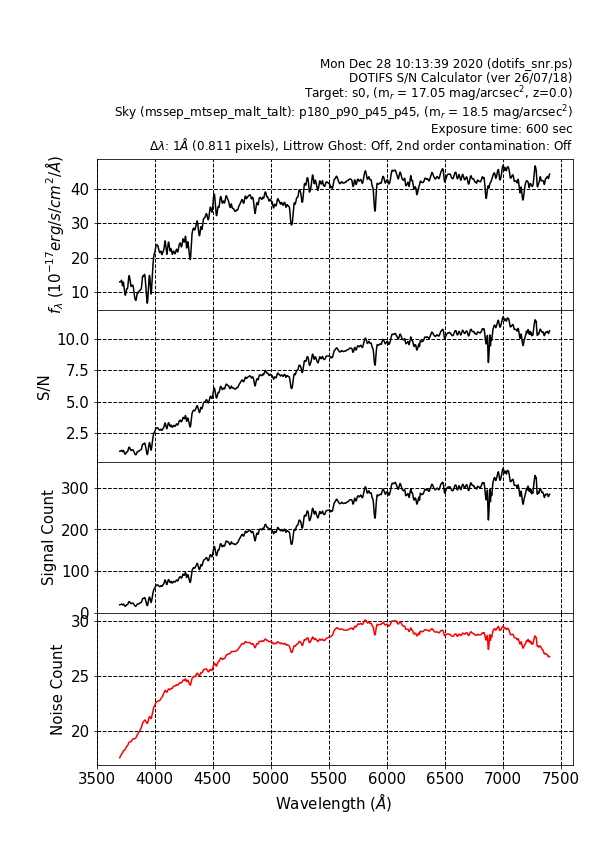

None


In [93]:
# etc=dotifsetc(exptime=600, 
#               source='obj_s0', z=0.00,
#       magnitude=17.05, skymagnitude=18.5, stype=3,
#               skytrans='skytrans',
# 		pixel=None, wstep=1, tscale=1, skysamplingsize=np.pi, sourcesamplingsize=1,
#               rmedsn=True, save=False, show=False, run=False)
# etc.pri=1.45255
# etc.pri=2
# etc.sec=etc.pri*0.3

# etc.pri=1.6
# etc.sec=etc.pri*0.5

# etc.show=True



# etc.run()
# etc.wave[1500]
# idxx=1500
# print(etc.signal[idxx],etc.noise[idxx], etc.sourcecount[idxx], etc.pc1st[idxx], etc.tsky[idxx], etc.t1st[idxx])

# print(etc.plot())